# Import

In [70]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pickle, json
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import *
from utils_test import *
from datas import *
from Transformers import Transformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

stock = "2454.TW"
short = False

def predict(test = True):
    
    MODEL = "Transformer"
    model = Transformer(test=True)
    model.load_state_dict(torch.load(f'result/{MODEL}_{stock}_best.pt'))
    model.to("cpu")
    
    if True:
        loader = tsmc.testloader if test else tsmc.validloader
    
    with torch.no_grad():
        model.eval()
        for x_test, y_test in loader:
            x_test = x_test.permute(0, 2, 1)    
            _, out = model(src=tsmc.src, tgt=x_test, train=True) # train, test set train = True, valid set False
            
    return out


def backtest(result, thres):
    
    asset = 1
    asset_buyhold = 1
    asset_hist = []
    asset_buyhold_hist = []
    ground_truth = tsmc.data["doc_1"].iloc[-out.shape[0]:]
    
    for doc_1, pred in zip(ground_truth, result):
        if pred > thres:
            asset *= (1 + doc_1/100)
        asset_hist.append(asset)
        
        asset_buyhold *= (1 + doc_1/100)
        asset_buyhold_hist.append(asset_buyhold)
    return asset_hist, asset_buyhold_hist, ground_truth.index


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
tsmc = Data(stock)
tsmc.prepareData()

out_valid = predict(test=False)
out = predict()
thres = out_valid.mean()

Shape:
            x_train: torch.Size([1959, 6, 10]), 
            x_valid: torch.Size([103, 6, 10]),
            x_test: torch.Size([109, 6, 10]),
            y_train: torch.Size([1959, 1]),
            y_valid: torch.Size([103, 1]),
            y_test: torch.Size([109, 1])


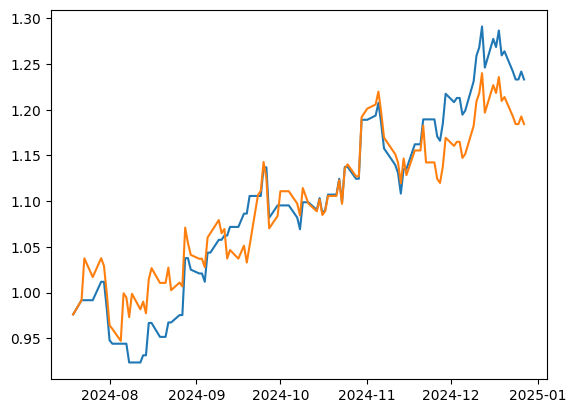

In [ ]:
asset_hist, asset_buyhold_hist, time = backtest(out, thres)

result = pd.DataFrame({"Model": asset_hist, "BuyHold": asset_buyhold_hist}).set_index(time)
plt.plot(result)